In [932]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools

In [ ]:
NUM_INPUT_NEURONS = 4  # 4 признака в Iris dataset
NUM_HIDDEN_NEURONS = [5,5]
NUM_OUTPUT_NEURONS = 3  # 3 класса в Iris
TIME_STEPS = 100  # Количество временных шагов для симуляции
TAU = 8  # Временная константа мембраны
THRESHOLD = 0.25  # Порог срабатывания
REST_POTENTIAL = 0.0  # Потенциал покоя
STDP_A_PLUS = 0.08  # Параметры STDP
STDP_A_MINUS = STDP_A_PLUS * 1.1
STDP_TAU = 6

In [934]:
class LIF:
    def __init__(self, input_count, tau, v_reset, v_threshold, relax_time):
        self.weights = np.zeros(input_count)
        self.tau = tau
        self.v_reset = v_reset
        self.v_threshold = v_threshold
        self.v = self.v_reset
        self.v_trace = []
        self.relax_time = relax_time
        self.relax_time_left = 0
        self.last_spike_time = -np.inf
        self.first_spike_time = np.inf
        self.spikes = []
        self.spike_trace = []

    def update(self, input_spikes, current_time, dt):
        current_input = input_spikes @ self.weights
        self.v += (-self.v + current_input) * dt / self.tau
        self.v_trace.append(self.v)

        spike = False
        if self.v >= self.v_threshold:
            spike = True
            if (self.first_spike_time > current_time):
                self.first_spike_time = current_time
            self.last_spike_time = current_time
            self.relax_time_left = self.relax_time
            self.v = self.v_reset
        elif self.relax_time_left > 0:
            self.relax_time_left -= dt
            self.v = self.v_reset

        if (spike):
            self.spikes.append(1)
            self.spike_trace.append(True)
        else:
            self.spikes.append(0)
            self.spike_trace.append(False)
        return spike
    
    def reset(self):
        self.v = self.v_reset
        self.last_spike_time = -np.inf
        self.first_spike_time = np.inf
        self.spikes = []
        self.relax_time_left = 0

class Classifier:
    def __init__(self, input_classes, hidden_sizes, output_clases, time_steps, time_per_step):
        self.input_classes = input_classes
        self.hidden_layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if (i == 0):
                self.hidden_layers.append([LIF(input_classes, TAU, REST_POTENTIAL, THRESHOLD, 0) for _ in range(hidden_size)])
            else:
                self.hidden_layers.append([LIF(hidden_sizes[i - 1], TAU, REST_POTENTIAL, THRESHOLD, 0) for _ in range(hidden_size)])
        self.output_layer = [LIF(hidden_sizes[len(hidden_sizes) - 1], TAU, REST_POTENTIAL, THRESHOLD, time_steps * time_per_step) for _ in range(output_clases)]
        self.time_steps = time_steps
        self.time_per_step = time_per_step
        self.A_p = STDP_A_PLUS
        self.A_m = STDP_A_MINUS
        self.stdp_tau = STDP_TAU

    def encode_input(self, X):
        spikes = np.zeros((len(X), self.input_classes, self.time_steps))
        for j in range(self.input_classes):
            min = np.min(X[:, j])
            max = np.max(X[:, j])
            for i in range(len(X)):
                rate = (X[i, j] - min) / (max - min + 1e-9)
                spikes[i, j, :] = np.random.rand(self.time_steps) < rate
        return spikes

    def test(self, X_test, y_test, print_per_sample=False):
        X_test_spikes = self.encode_input(X_test)
        return self.forward(X_test_spikes, y_test, print_per_sample=print_per_sample)

    def randomize_weights(self):
        for neuron in (itertools.chain.from_iterable(self.hidden_layers + [self.output_layer])):
            neuron.weights = np.random.rand(len(neuron.weights))

    def forward(self, X_spikes, y, stdp=False, print_per_sample=False):
        correct = 0
        results = np.zeros((len(self.output_layer) + 1, len(self.output_layer)))
        for sample_idx in range(len(X_spikes)):
            # Сброс нейронов
            for neuron in (itertools.chain.from_iterable(self.hidden_layers + [self.output_layer])):
                neuron.reset()

            output_spike_times = np.zeros(len(self.output_layer))

            current_time = 0
            # Для каждого временного промежутка
            for current_time_step in range(self.time_steps):
                # Получаем входные спайки для этого временного шага
                input_spikes = X_spikes[sample_idx, :, current_time_step]
                
                # Обновляем скрытые нейроны
                for hidden_layer in self.hidden_layers:
                    hidden_spikes = np.zeros(len(hidden_layer))
                    for i, neuron in enumerate(hidden_layer):
                        hidden_spikes[i] = neuron.update(input_spikes, current_time, self.time_per_step)
                    input_spikes = hidden_spikes

                # Обновляем выходные нейроны
                output_spikes = np.zeros(len(self.output_layer))
                for i, neuron in enumerate(self.output_layer):
                    output_spikes[i] = neuron.update(input_spikes, current_time, self.time_per_step)
                    output_spike_times[i] = neuron.first_spike_time

                current_time += self.time_per_step

            if (stdp):
                self.stdp(X_spikes, y, sample_idx)

            #Считаем точность
            if np.all(~np.isfinite(output_spike_times)):
                predicted = -1
            else:
                predicted = np.argmin(output_spike_times)

            for i, neuron in enumerate(self.output_layer):
                results[predicted + 1, y[sample_idx]] += 1

            if (print_per_sample):
                print(f"Predicted: {predicted}, Correct: {y[sample_idx]}")
            

            if predicted == y[sample_idx]:
                correct += 1

        for i in range(len(self.output_layer) + 1):
            print(f"neuron {i - 1}: 0 = {(results[i, 0] / np.sum(results[i, :]) * 100):2f}; 1 = {(results[i, 1] / np.sum(results[i, :]) * 100):2f}; 2 = {(results[i, 2] / np.sum(results[i, :]) * 100):2f}; count = {np.sum(results[i, :])}")
        print()

        return correct / len(X_spikes) * 100

    def stdp(self, X_spikes, y, sample_idx):
        # Получаем входные спайки для этого временного шага
        input_spikes = X_spikes[sample_idx, :, :]

        # Применяем STDP для скрытЫх слоёв
        for hidden_layer in self.hidden_layers:
            self.stdp_layer(hidden_layer, input_spikes)

        # Применяем STDP для выходного слоя
        self.stdp_supervised_output_layer(y[sample_idx], [neuron.spikes for neuron in self.hidden_layers[len(self.hidden_layers) - 1]])

    def stdp_layer(self, layer, input_spikes):
        dw_inc = 0
        dw_dec = 0
        for i, neuron in enumerate(layer):
            for t_post, spike_post in enumerate(neuron.spikes):
                if (spike_post <= 0):
                    continue
                for j, input_neuron_spikes in enumerate(input_spikes):
                    for t_pre, spike_pre in enumerate(input_neuron_spikes):
                        if (spike_pre <= 0):
                            continue

                        delta_t = (t_post - t_pre) * self.time_per_step

                        if delta_t < 0:
                            dw = self.A_p * np.exp(delta_t / self.stdp_tau)
                            dw_inc += 1
                            #print(f"dw_inc = {dw}")
                        else:
                            dw = -self.A_m * np.exp(-delta_t / self.stdp_tau)
                            dw_dec += 1
                            #print(f"dw_dec = {dw}")

                        neuron.weights[j] += dw
                        if (neuron.weights[j] < 0):
                            neuron.weights[j] = max(neuron.weights[j], 1e-3)

                        neuron.weights /= np.linalg.norm(neuron.weights) + 1e-6

                neuron.weights /= np.linalg.norm(neuron.weights) + 1e-6

        #print (f"dw_inc: {dw_inc}; dw_dec: {dw_dec}")
        #self.print_weights()

    def stdp_supervised_output_layer(self, correct_class, input_spikes):
        for i, neuron in enumerate(self.output_layer):
            target = (i == correct_class)
            for t_post, spike_post in enumerate(neuron.spikes):
                if not spike_post:
                    continue
                for j, input_neuron_spikes in enumerate(input_spikes):
                    for t_pre, spike_pre in enumerate(input_neuron_spikes):
                        if not spike_pre:
                            continue

                        delta_t = (t_post - t_pre) * self.time_per_step

                        if target:
                            # усиливаем, если правильный нейрон
                            if delta_t < 0:
                                dw = self.A_p * np.exp(delta_t / self.stdp_tau)
                            else:
                                dw = -self.A_m * np.exp(-delta_t / self.stdp_tau)
                        else:
                            # подавляем, если неправильный нейрон
                            if delta_t < 0:
                                dw = -self.A_p * np.exp(delta_t / self.stdp_tau)
                            else:
                                dw = self.A_m * np.exp(-delta_t / self.stdp_tau)

                        neuron.weights[j] += dw
                        neuron.weights[j] = max(neuron.weights[j], 1e-3)

                # нормализация весов
                neuron.weights /= np.linalg.norm(neuron.weights) + 1e-6

    def train(self, X_train, y_train, epochs=10):
        X_train_spikes = self.encode_input(X_train)
        for epoch in range(epochs):
            self.clear_potential_history()
            accuracy = self.forward(X_train_spikes, y_train, True)
            print(f"Epoch: {epoch}; Accuracy: {accuracy}")

        for hidden_layer in self.hidden_layers:
            self.plot_potential_history(hidden_layer)
        self.plot_potential_history(self.output_layer)

    def clear_potential_history(self):
        for neuron in (itertools.chain.from_iterable(self.hidden_layers + [self.output_layer])):
            neuron.v_trace = []
            neuron.spike_trace = []

    def plot_potential_history(self, neurons):
        for i, neuron in enumerate(neurons):
            plt.figure(figsize=(8, 4))
            plt.plot(neuron.v_trace, label='Membrane potential', linewidth=1, zorder=1)

            # Отметим спайки крестиками
            spike_times = [t for t, spike in enumerate(neuron.spike_trace) if spike]
            spike_values = [neuron.v_threshold] * len(spike_times)  # по уровню порога
            plt.scatter(spike_times, spike_values, color='red', marker='x', label='Spike', zorder=2)

            plt.xlabel('Time step')
            plt.ylabel('Membrane potential')
            plt.title(f'Output Neuron {i} Potential & Spikes')
            plt.axhline(neuron.v_threshold, color='gray', linestyle='--', label='Threshold')
            plt.ylim(min(neuron.v_trace) - 0.5, neuron.v_threshold + 1)

            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    def print_weights(self):
        print("Hidden weights:")
        for hidden_layer in self.hidden_layers:
            for neuron in hidden_layer:
                print(neuron.weights)

        print("Output weights:")
        for neuron in self.output_layer:
            print(neuron.weights)


In [935]:
# Загружаем датасет Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Масштабируем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X[0:]

In [936]:
X_train = np.concatenate((X[0:30], X[50:80], X[100:130]))
X_test = np.concatenate((X[30:50], X[80:100], X[130:150]))
y_train = np.concatenate((y[0:30], y[50:80], y[100:130]))
y_test = np.concatenate((y[30:50], y[80:100], y[130:150]))

In [ ]:
classifier = Classifier(NUM_INPUT_NEURONS, NUM_HIDDEN_NEURONS, NUM_OUTPUT_NEURONS, 100, 1)
classifier.randomize_weights()

neuron -1: 0 = 80.000000; 1 = 10.000000; 2 = 10.000000; count = 90.0
neuron 0: 0 = 2.040816; 1 = 42.857143; 2 = 55.102041; count = 147.0
neuron 1: 0 = 71.428571; 1 = 28.571429; 2 = 0.000000; count = 21.0
neuron 2: 0 = 0.000000; 1 = 100.000000; 2 = 0.000000; count = 12.0

Epoch: 0; Accuracy: 3.3333333333333335
neuron -1: 0 = 79.310345; 1 = 10.344828; 2 = 10.344828; count = 87.0
neuron 0: 0 = 11.475410; 1 = 44.262295; 2 = 44.262295; count = 183.0
neuron 1: 0 = nan; 1 = nan; 2 = nan; count = 0.0
neuron 2: 0 = nan; 1 = nan; 2 = nan; count = 0.0

Epoch: 1; Accuracy: 7.777777777777778


C:\Users\user\AppData\Local\Temp\ipykernel_25052\1556150600.py:133: RuntimeWarning: invalid value encountered in scalar divide
  print(f"neuron {i - 1}: 0 = {(results[i, 0] / np.sum(results[i, :]) * 100):2f}; 1 = {(results[i, 1] / np.sum(results[i, :]) * 100):2f}; 2 = {(results[i, 2] / np.sum(results[i, :]) * 100):2f}; count = {np.sum(results[i, :])}")


neuron -1: 0 = 79.310345; 1 = 10.344828; 2 = 10.344828; count = 87.0
neuron 0: 0 = 11.475410; 1 = 44.262295; 2 = 44.262295; count = 183.0
neuron 1: 0 = nan; 1 = nan; 2 = nan; count = 0.0
neuron 2: 0 = nan; 1 = nan; 2 = nan; count = 0.0

Epoch: 2; Accuracy: 7.777777777777778


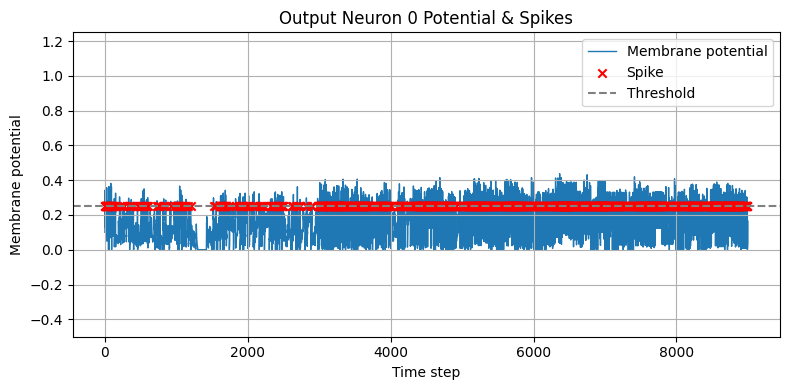

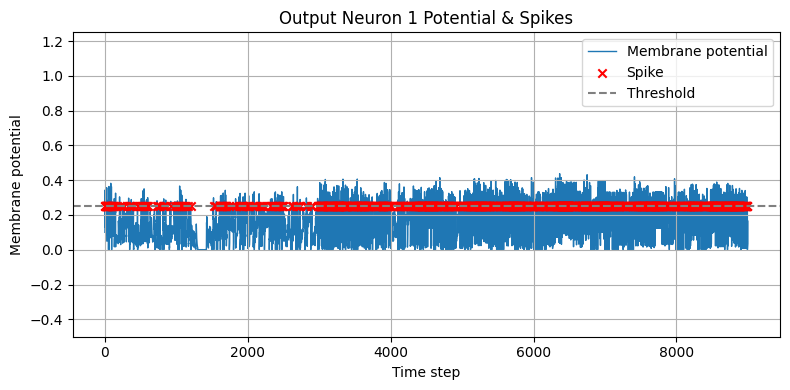

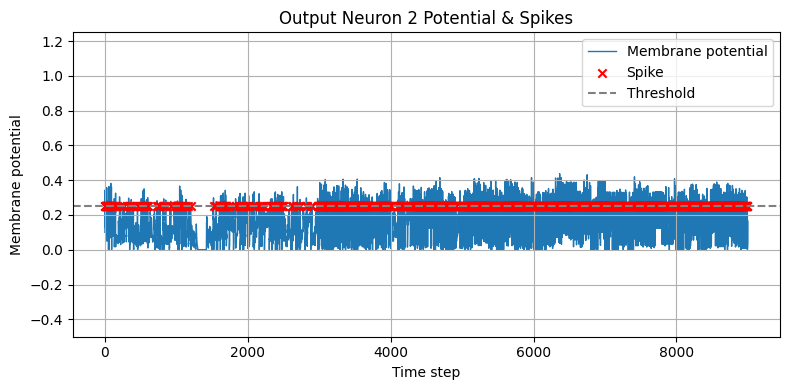

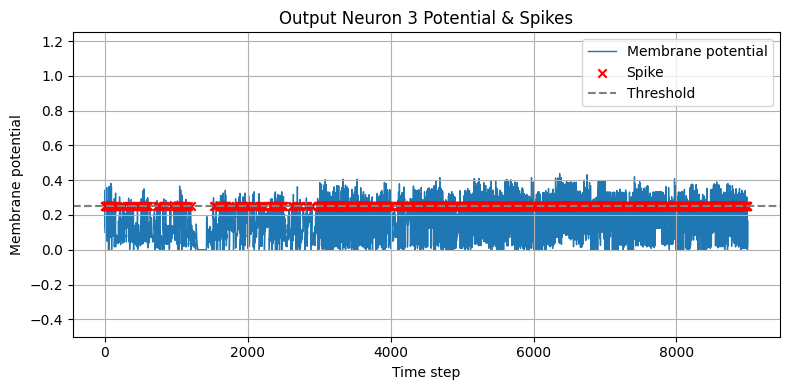

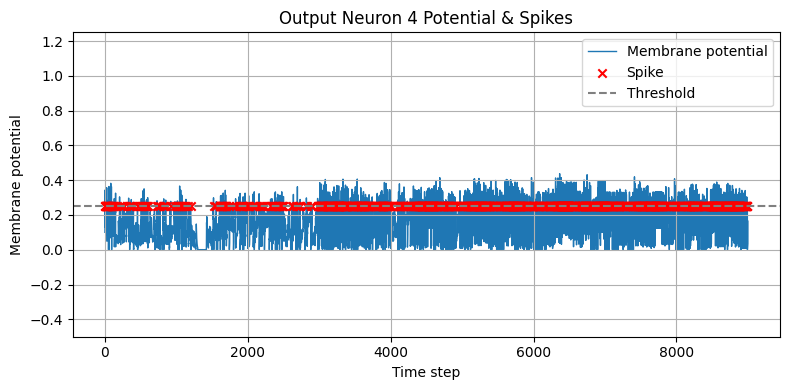

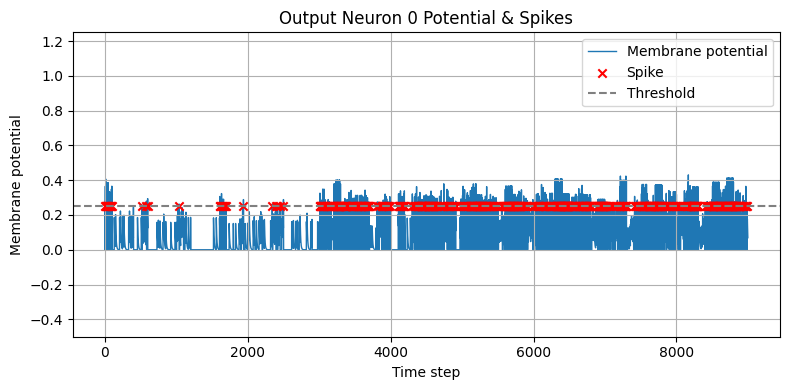

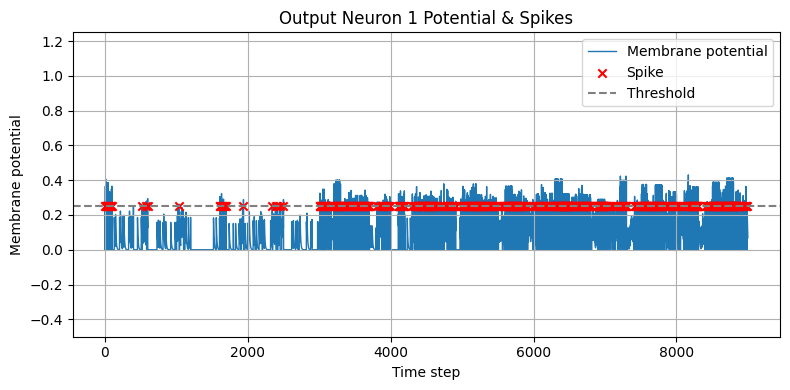

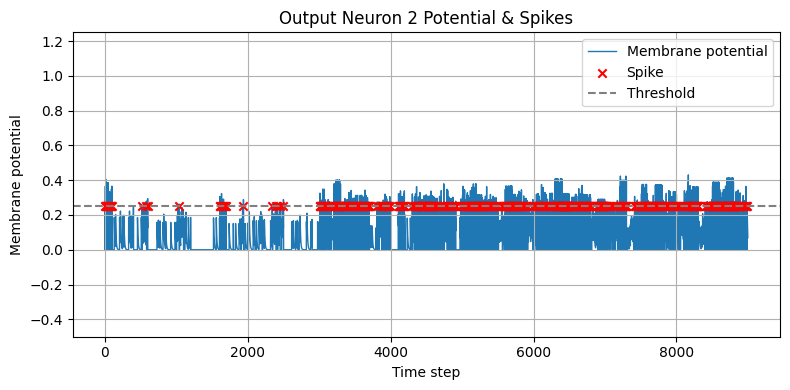

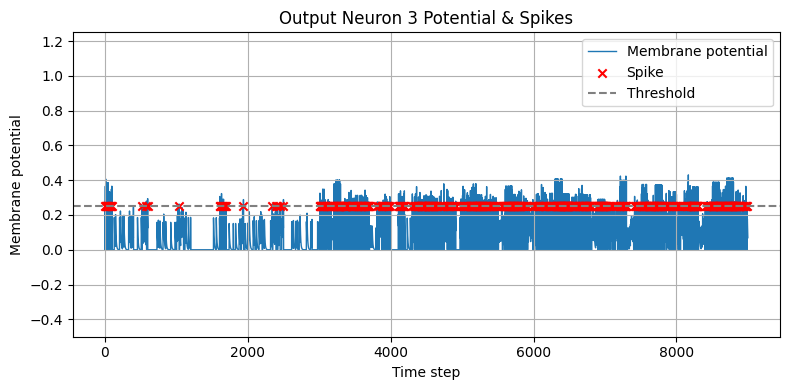

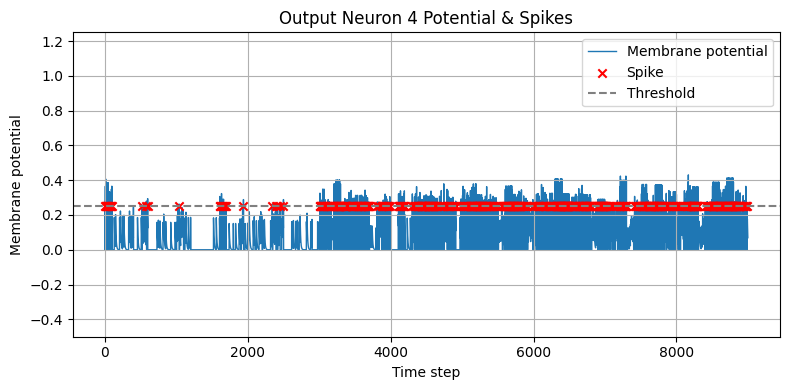

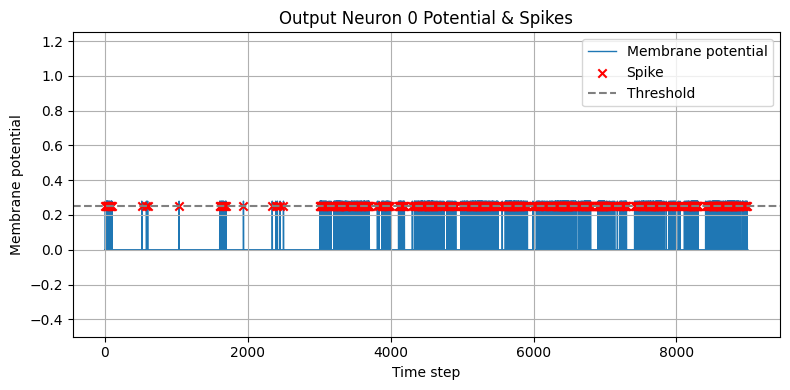

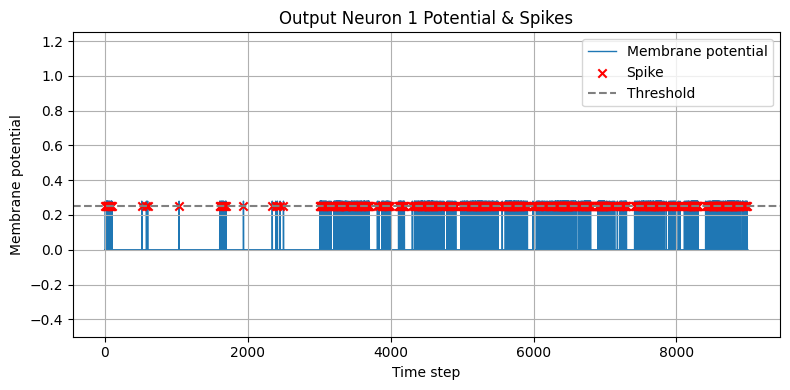

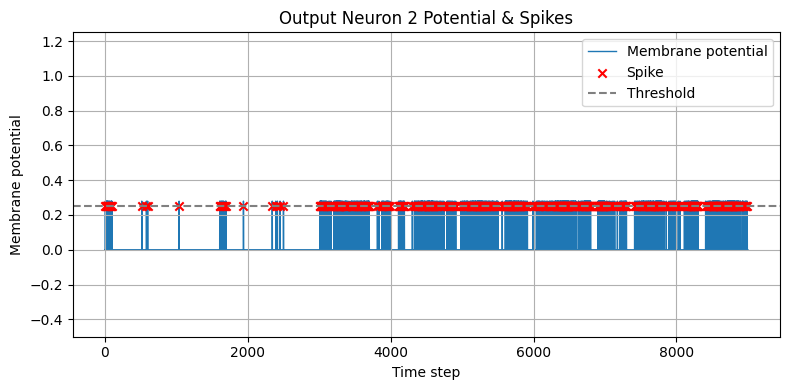

In [938]:
classifier.train(X_train, y_train, 3)

In [939]:
classifier.test(X_test, y_test, True)

Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: -1, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1

C:\Users\user\AppData\Local\Temp\ipykernel_25052\1556150600.py:133: RuntimeWarning: invalid value encountered in scalar divide
  print(f"neuron {i - 1}: 0 = {(results[i, 0] / np.sum(results[i, :]) * 100):2f}; 1 = {(results[i, 1] / np.sum(results[i, :]) * 100):2f}; 2 = {(results[i, 2] / np.sum(results[i, :]) * 100):2f}; count = {np.sum(results[i, :])}")


31.666666666666664